# Pruebas de Hipótesis: Tornillos y Temperatura Corporal
En este notebook se resuelven dos problemas clásicos de pruebas de hipótesis para medias, usando Python y librerías estadísticas.

---

## Configuración del entorno
Importaremos SciPy/NumPy y definiremos funciones auxiliares para prueba z de una media con desviación estándar conocida y cálculo de intervalos.

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

def z_test_media(xbar: float, mu0: float, sigma: float, n: int, alpha: float) -> dict:
    """Prueba z bilateral para la media con sigma conocida. Devuelve estadístico, p-valor y decisión."""
    se = sigma / np.sqrt(n)                   # Error estándar
    z_stat = (xbar - mu0) / se                # Estadístico z
    p_value = 2 * (1 - norm.cdf(abs(z_stat))) # p-valor
    z_crit = norm.ppf(1 - alpha/2)            # Valor crítico z
    reject = abs(z_stat) > z_crit             # Decisión
    ci_half = z_crit * se                     # Mitad del intervalo de confianza
    ci = (xbar - ci_half, xbar + ci_half)     # Intervalo de confianza
    return {
        "alpha": alpha,
        "z_stat": z_stat,
        "p_value": p_value,
        "z_crit": z_crit,
        "reject_H0": reject,
        "ci_lower": ci[0],
        "ci_upper": ci[1],
        "se": se,
        "n": n,
        "xbar": xbar,
        "mu0": mu0,
        "sigma": sigma
    }

def resumen_pruebas(xbar: float, mu0: float, sigma: float, n: int, alphas: list[float]) -> pd.DataFrame:
    resultados = [z_test_media(xbar, mu0, sigma, n, a) for a in alphas]
    df = pd.DataFrame(resultados)
    df["confianza"] = (1 - df["alpha"]) * 100
    cols = ["confianza","alpha","z_stat","z_crit","p_value","reject_H0","ci_lower","ci_upper"]
    return df[cols]

def plot_ci_errorbar(tabla: pd.DataFrame, mu0: float, xbar: float, xlabel: str, title: str):
    """Visualiza intervalos de confianza como barras de error horizontales centradas en x̄."""
    fig, ax = plt.subplots(figsize=(8, 2.8 + 0.5 * len(tabla)))
    y = np.arange(len(tabla))
    left = xbar - tabla['ci_lower'].to_numpy()
    right = tabla['ci_upper'].to_numpy() - xbar
    ax.errorbar(xbar * np.ones_like(y), y, xerr=[left, right],
                fmt='o', color='black', ecolor='steelblue', elinewidth=2, capsize=4, label='x̄ ± CI')
    ax.axvline(mu0, color='red', linestyle='--', lw=1.8, label='μ₀')
    ax.set_yticks(y)
    ax.set_yticklabels([f"{int(c)}% (α={a})" for c, a in zip(tabla['confianza'], tabla['alpha'])])
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(True, axis='x', alpha=0.3)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def plot_sampling_mean_hist(mu0: float, sigma: float, n: int, alpha: float = 0.05,
                            sims: int = 10000, xbar: float | None = None,
                            xlabel: str = 'Media muestral', title: str = 'Distribución de x̄ bajo H0'):
    """Histograma de la distribución de x̄ bajo H0: N(μ0, σ/√n). Marca μ₀, x̄ y umbrales críticos ±zα/2·SE."""
    se = sigma / np.sqrt(n)
    xs = np.random.normal(loc=mu0, scale=se, size=sims)
    zcrit = norm.ppf(1 - alpha/2)
    lower = mu0 - zcrit * se
    upper = mu0 + zcrit * se

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(xs, bins=30, color='tab:blue', alpha=0.7, edgecolor='white')
    ax.axvline(mu0, color='red', linestyle='--', lw=1.8, label='μ₀')
    ax.axvline(lower, color='gray', linestyle=':', lw=1.5, label='Umbral α/2')
    ax.axvline(upper, color='gray', linestyle=':', lw=1.5)
    if xbar is not None:
        ax.axvline(xbar, color='black', lw=1.8, label='x̄')

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'{title} (α={alpha})')
    ax.grid(True, axis='y', alpha=0.3)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    return {"se": se, "lower": lower, "upper": upper}

## Problema 1: Tornillos y tolerancia de longitud
Una máquina fabrica tornillos cuyo valor nominal debe ser de 800 milímetros de largo, con una desviación estándar de 5 mm. Se toma una muestra aleatoria de 40 tornillos y se obtiene una longitud promedio de 790 mm. Determinar si el largo promedio está en la tolerancia con niveles de significancia de 1%, 5% y 10%.

**Hipótesis nula ($H_0$):**  
La media poblacional es igual al valor nominal.  
$H_0: \mu = 800$

**Hipótesis alternativa ($H_1$):**  
La media poblacional es diferente al valor nominal.  
$H_1: \mu \neq 800$

### Problema 1: Tornillos (prueba z bilateral)
Parámetros: $\mu_0=800$ mm, $\sigma=5$ mm (conocida), $n=40$, $\bar{x}=790$ mm. Se evalúa a niveles $\alpha\in\{0.01,0.05,0.10\}$.

   confianza  alpha     z_stat    z_crit  p_value  reject_H0    ci_lower  \
0       99.0   0.01 -12.649111  2.575829      0.0       True  787.963628   
1       95.0   0.05 -12.649111  1.959964      0.0       True  788.450512   
2       90.0   0.10 -12.649111  1.644854      0.0       True  788.699629   

     ci_upper  
0  792.036372  
1  791.549488  
2  791.300371  


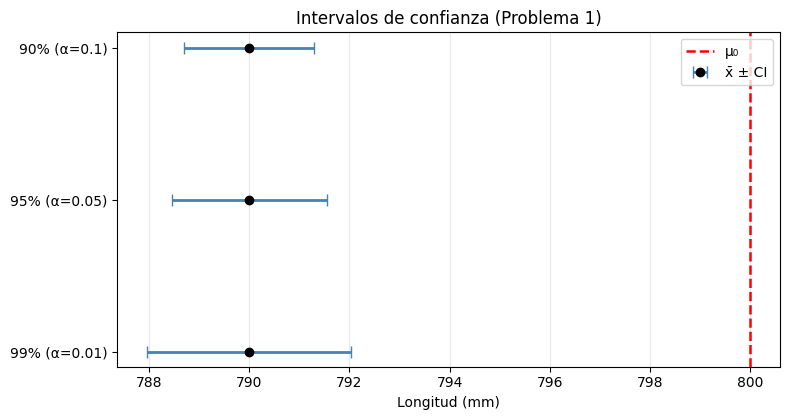

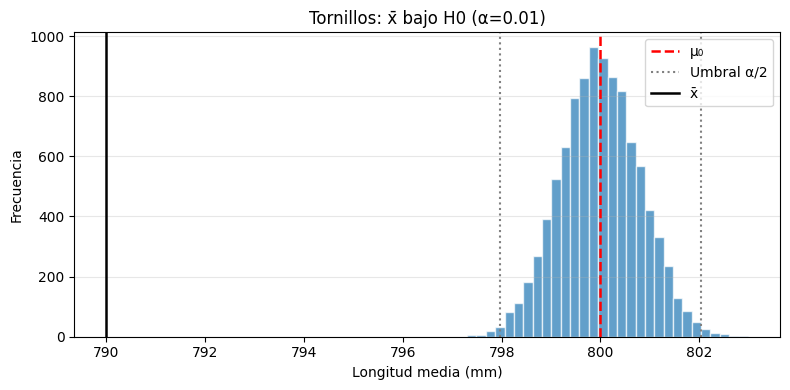

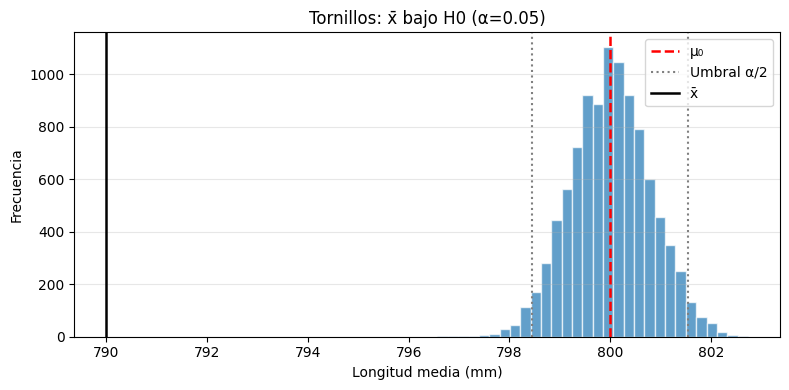

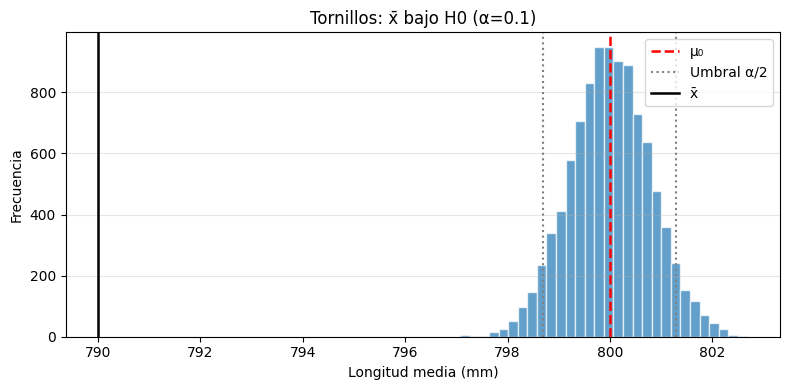

In [7]:
mu0_1 = 800.0                # media poblacional bajo H0 (mm)
sigma_1 = 5.0                # desviación estándar conocida (mm)
n_1 = 40                     # tamaño de la muestra
xbar_1 = 790.0               # media muestral (mm)
niveles = [0.01, 0.05, 0.10] # niveles de significancia

tabla_1 = resumen_pruebas(xbar_1, mu0_1, sigma_1, n_1, niveles)
print(tabla_1)

plot_ci_errorbar(tabla_1, mu0_1, xbar_1, xlabel='Longitud (mm)', title='Intervalos de confianza (Problema 1)')
for a in niveles:
    plot_sampling_mean_hist(mu0_1, sigma_1, n_1, alpha=a, xbar=xbar_1,
                             xlabel='Longitud media (mm)', title='Tornillos: x̄ bajo H0')

Interpretación breve: si `reject_H0` es verdadero a un cierto nivel, concluimos que la evidencia sugiere que la media difiere de 800 mm a ese nivel de significancia. El intervalo de confianza asociado excluye 800 si y solo si se rechaza $H_0$.

---
## Problema 2: Temperatura corporal (prueba z bilateral, $\alpha=0.01$)

Wunderlich reportó 98.6°F como temperatura promedio corporal. En una muestra moderna: $n=148$, $\bar{x}=98.24923$°F, $\sigma=0.63$°F (conocida). Evaluar si la media difiere de 98.6°F con $\alpha=0.01$.

Carl Reinhold August Wunderlich fue un médico pionero en la medición de la temperatura promedio del cuerpo humano saludable, estableciendo el estándar de 98.6°F. Casi 150 años después, investigadores de la Universidad de Maryland evaluaron este valor midiendo la temperatura corporal de 148 hombres y mujeres sanos, obteniendo un promedio de 98.24923°F. Con la desviación estándar tradicionalmente conocida de la temperatura corporal humana de aproximadamente 0.63°F, ¿hay evidencia, a un nivel de significancia del 1%, de que la verdadera temperatura promedio del cuerpo humano difiere de 98.6°F?

**Hipótesis nula ($H_0$):**  
La temperatura promedio poblacional es igual al estándar histórico.  
$H_0: \mu = 98.6$

**Hipótesis alternativa ($H_1$):**  
La temperatura promedio poblacional es diferente al estándar histórico.  
$H_1: \mu \neq 98.6$

   confianza  alpha    z_stat    z_crit       p_value  reject_H0   ci_lower  \
0       99.0   0.01 -6.777935  2.575829  1.219047e-11       True  98.115609   

    ci_upper  
0  98.382391  


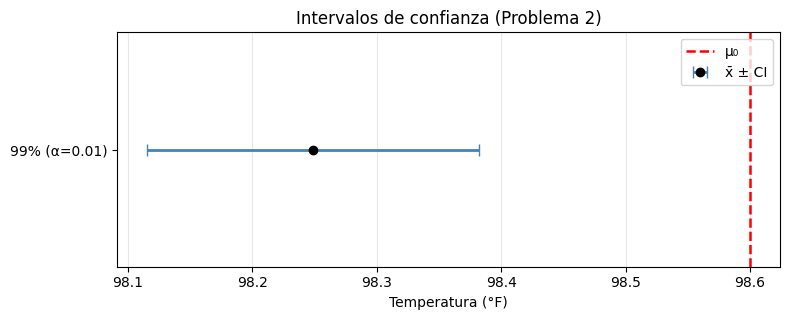

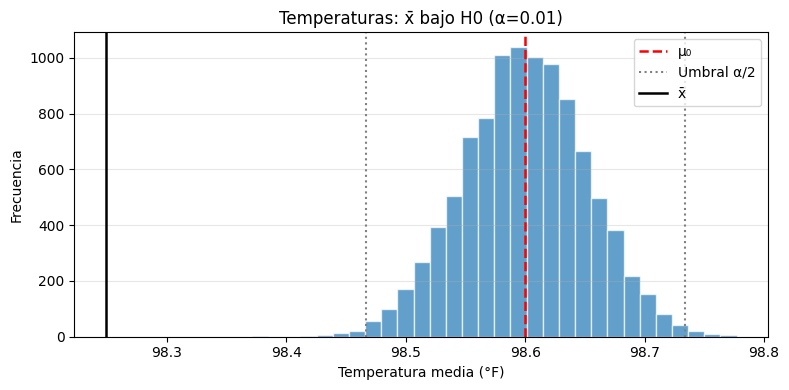

{'se': np.float64(0.05178568100118755),
 'lower': np.float64(98.4666089253729),
 'upper': np.float64(98.7333910746271)}

In [12]:
mu0_2 =  98.6     # valor poblacional bajo H0 (°F)
sigma_2 =  0.63   # desviación estándar conocida
n_2 =  148       # tamaño de la muestra
xbar_2 = 98.249  # media muestral (°F)
alpha2_2 = 0.01  # nivel de significancia

resultado_2 = z_test_media(xbar_2, mu0_2, sigma_2, n_2, alpha_2)
tabla_2 = resumen_pruebas(xbar_2, mu0_2, sigma_2, n_2, [alpha_2])
print(tabla_2)

plot_ci_errorbar(tabla_2, mu0_2, xbar_2, xlabel='Temperatura (°F)', title='Intervalos de confianza (Problema 2)')
plot_sampling_mean_hist(mu0_2, sigma_2, n_2, alpha=alpha_2, xbar=xbar_2,
                            xlabel='Temperatura media (°F)', title='Temperaturas: x̄ bajo H0')

Interpretación breve: si `reject_H0=True`, la evidencia apoya que la temperatura promedio difiere de 98.6°F al 1%. El intervalo de confianza al 99% no debe contener 98.6°F en ese caso.